# Imports

In [ ]:
!pip install pyspark

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, round, max, min, col, datediff, current_date, to_date, udf, count
from pyspark.sql.types import DoubleType, StructType, StructField, StringType, IntegerType, DateType
import seaborn as sns
import matplotlib.pyplot as plt

# Configs

In [3]:
# Initialize a SparkSession with a specific application name 'Case Oper'
spark = SparkSession.builder.appName('Case Oper').getOrCreate()

# Define the path to the World Cup dataset CSV file
path_world_cup = '/content/drive/MyDrive/Colab Notebooks/teste-tecnico-main/base_copa2018.csv'

# Path where Parquet files will be saved
output_path = "/content/drive/MyDrive/Colab Notebooks/teste-tecnico-main/outputs/first_question"

In [4]:
# Define the schema for the DataFrame
schema = StructType([
    StructField("team", StringType(), True),
    StructField("jersey_number", IntegerType(), True),
    StructField("position", StringType(), True),
    StructField("fifa_popular_name", StringType(), True),
    StructField("birth_date", StringType(), True),
    StructField("shirt_name",  StringType(), True),
    StructField("club", StringType(), True),
    StructField("height", IntegerType(), True),
    StructField("weight", IntegerType(), True)
])

In [6]:
# Read the CSV file using SparkSession
df = spark.read.format("csv") \
             .option("header", "true") \
             .schema(schema) \
             .load(path_world_cup)

# Fisrt question

## Functions

In [7]:
def calc_ave_max_min(df, group_col, agg_col):
    """
    Calculates the average, maximum, and minimum values of a column aggregated by a grouping column.

    Args:
    - df (DataFrame): Spark DataFrame containing the data.
    - group_col (str): Name of the column to group by.
    - agg_col (str): Name of the column to aggregate (e.g., "Height", "Weight").

    Returns:
    - avg_df (DataFrame): DataFrame with the average value of agg_col for each group.
    - max_team_df (Row): Row containing the group with the highest average value of agg_col.
    - min_team_df (Row): Row containing the group with the lowest average value of agg_col.
    """
    # Calculate average for each group
    avg_df = df.groupBy(group_col).agg(round(avg(agg_col), 2).alias(f"average_{agg_col}"))

    # Find group with maximum average value
    max_team_df = avg_df.orderBy(f"average_{agg_col}", ascending=False).first()

    # Find group with minimum average value
    min_team_df = avg_df.orderBy(f"average_{agg_col}", ascending=True).first()

    return avg_df, max_team_df, min_team_df

In [8]:
def calc_bmi(weight, height):
    """
    Calculate Body Mass Index (BMI) given weight in kilograms and height in centimeters.

    Args:
    - weight (float or int): Weight of the person in kilograms.
    - height (float or int): Height of the person in centimeters.

    Returns:
    - float: Body Mass Index (BMI) calculated as weight / (height / 100)^2.

    Raises:
    - ValueError: If height is non-positive (<= 0).

    Notes:
    - BMI is a measure of body fat based on weight and height.
    - Height must be provided in centimeters for accurate calculation.

    Example:
    >>> calc_bmi(70, 175)
    22.86
    """
    if height <= 0:
        raise ValueError("Height must be positive and non-zero.")

    # Convert height to meters
    height_meters = height / 100.0

    # Calculate BMI
    bmi = weight / (height_meters ** 2)

    return bmi

In [9]:
def get_position_data(df, position_col, value_col):
    """
    Extracts data for different player positions based on a specified value column.

    Args:
    - df (DataFrame): The input DataFrame containing player data.
    - position_col (str): Name of the column indicating player positions (e.g., "Position").
    - value_col (str): Name of the column containing numerical values to sort and limit by.

    Returns:
    Tuple: A tuple containing DataFrames for goalkeepers, defenders, midfielders, and forwards
           sorted by the specified value column in descending order:
           (goalkeepers, defenders, midfielders, forwards)
    """

    goalkeepers = df.filter(col("Position") == "GK").orderBy(col(value_col).desc()).limit(1)
    defenders = df.filter(col("Position") == "DF").orderBy(col(value_col).desc()).limit(4)
    midfielders = df.filter(col("Position") == "MF").orderBy(col(value_col).desc()).limit(4)
    forwards = df.filter(col("Position") == "FW").orderBy(col(value_col).desc()).limit(2)

    return goalkeepers, defenders, midfielders, forwards

In [10]:
# Create a User Defined Function (UDF) to calculate Body Mass Index (BMI).
bmi_udf = udf(calc_bmi, DoubleType())

## 1.1
selection height average

In [11]:
# Calculate average, maximum, and minimum height for each team in the dataframe
avg_height_df, max_height_team, min_height_team = calc_ave_max_min(df, "team", "height")

In [12]:
avg_height_df.show()

+--------------+--------------+
|          team|average_height|
+--------------+--------------+
|        Russia|        184.39|
|       Senegal|        183.65|
|        Sweden|        185.74|
|       IR Iran|        184.48|
|       Germany|        185.78|
|        France|         183.3|
|     Argentina|        178.43|
|       Belgium|        185.35|
|          Peru|        177.61|
|       Croatia|        185.26|
|       Nigeria|        184.52|
|Korea Republic|        181.87|
|         Spain|        179.91|
|       Denmark|        186.61|
|       Morocco|         182.7|
|        Panama|        182.17|
|       Iceland|        185.52|
|       Uruguay|        181.04|
|        Mexico|        179.78|
|       Tunisia|        183.09|
+--------------+--------------+
only showing top 20 rows



In [ ]:
print(max_height_team, min_height_team)

Row(team='Serbia', average_height=186.7) Row(team='Peru', average_height=177.61)


## 1.2
selection weight average

In [ ]:
# Calculate average, maximum, and minimum weight for each team in the dataframe
avg_weight_df, max_weight_team, min_weight_team = calc_ave_max_min(df, "team", "weight")

In [ ]:
avg_weight_df.show()

+--------------+--------------+
|          team|average_weight|
+--------------+--------------+
|        Russia|         77.61|
|       Senegal|         76.83|
|        Sweden|         78.83|
|       IR Iran|         78.13|
|       Germany|         80.04|
|        France|          80.0|
|     Argentina|         75.57|
|       Belgium|         79.57|
|          Peru|         75.87|
|       Croatia|          79.3|
|       Nigeria|         80.48|
|Korea Republic|         74.43|
|         Spain|         74.74|
|       Denmark|         82.61|
|       Morocco|         74.65|
|        Panama|          80.0|
|       Iceland|         80.74|
|       Uruguay|         74.61|
|        Mexico|         74.09|
|       Tunisia|          75.0|
+--------------+--------------+
only showing top 20 rows



In [ ]:
print(max_weight_team, min_weight_team)


Row(team='Denmark', average_weight=82.61) Row(team='Japan', average_weight=71.52)


## 1.3
selection club age media

In [ ]:
# Only cast
df = df.withColumn("birth_date", to_date(col("birth_date"), "dd.MM.yyyy"))

In [ ]:
# Adding a new column "age" to the DataFrame `df` by calculating the difference
df_with_age = df.withColumn("age", (datediff(current_date(), col("birth_date")) / 365.25).cast("int"))

In [ ]:
# Grouping the DataFrame `df_with_age` by "Club" and calculating the average
avg_age_df = df_with_age.groupBy("club").agg(round(avg("age"), 2).alias("average_age"))

In [ ]:
# Only to show
avg_age_df.show()

+--------------------+-----------+
|                club|average_age|
+--------------------+-----------+
|FC Bayern München...|      32.91|
|Nottingham Forest...|       37.0|
|   Al Nassr FC (KSA)|      35.67|
|Athletic Bilbao (...|       29.0|
|   Grêmio FBPA (BRA)|       38.0|
| Stoke City FC (ENG)|       31.8|
|      KRC Genk (BEL)|       39.0|
|   Valencia CF (ESP)|       30.0|
|  Atromitos FC (GRE)|       30.0|
|   Toulouse FC (FRA)|      35.33|
|    SSC Napoli (ITA)|       34.0|
|Leeds United FC (...|       33.0|
|CA Boca Juniors (...|      29.75|
|  Legia Warsaw (POL)|       36.0|
|   Millwall FC (ENG)|       40.0|
|Vancouver Whiteca...|       36.0|
|  FSV Mainz 05 (GER)|       33.0|
|  Plaza Amador (PAN)|       33.0|
|FC Spartak Moscow...|       33.0|
|   Al Batin FC (KSA)|       39.0|
+--------------------+-----------+
only showing top 20 rows



## 1.4
team with the highest BMI in the competition

In [ ]:
# Adding a new column "BMI" to the DataFrame `df` using the UDF `bmi_udf`.
df_with_bmi = df.withColumn("bmi", bmi_udf(col("weight"), col("height")))

In [ ]:
# Finding the player with the highest BMI by sorting the DataFrame in descending order based on the "BMI" column.
max_bmi_player = df_with_bmi.orderBy(col("bmi").desc()).first()

In [ ]:
# Extracting the club name of the player with the highest BMI from the DataFrame.
club_with_player_max_bmi = max_bmi_player['club']

In [ ]:
print(max_bmi_player, club_with_player_max_bmi)

Row(team='Saudi Arabia', jersey_number=1, position='GK', fifa_popular_name='ABDULLAH ALMUAIOUF', birth_date=datetime.date(1987, 1, 23), shirt_name='ABDULLAH', club='Al Hilal SFC (KSA)', height=178, weight=98, bmi=30.930438076000502) Al Hilal SFC (KSA)


## 1.5
team with the lowest BMI in the competition

In [ ]:
# Extracting the player with the lowest BMI from the DataFrame.
min_bmi_player = df_with_bmi.orderBy(col("bmi").asc()).first()

In [ ]:
# Getting the club of the player with the lowest BMI from the DataFrame.
club_with_player_min_bmi = min_bmi_player['club']

In [ ]:
print(min_bmi_player, club_with_player_min_bmi)

Row(team='Portugal', jersey_number=16, position='MF', fifa_popular_name='BRUNO FERNANDES', birth_date=datetime.date(1994, 9, 8), shirt_name='B. FERNANDES', club='Sporting CP (POR)', height=183, weight=64, bmi=19.1107527844964) Sporting CP (POR)


## 1.6
Oldest player in the competition

In [ ]:
# Finding the oldest player by sorting the DataFrame 'df_with_age' in descending order of age
oldest_player = df_with_age.orderBy(col("age").desc()).first()

In [ ]:
oldest_player

Row(team='Egypt', jersey_number=1, position='GK', fifa_popular_name='ESSAM EL HADARY', birth_date=datetime.date(1973, 1, 15), shirt_name='ELHADARY', club='Al Taawoun FC (KSA)', height=190, weight=90, age=51)

## 1.7
Youngest player in the competition

In [ ]:
# Finding the youngest player by sorting the DataFrame 'df_with_age' in ascending order of age
youngest_player = df_with_age.orderBy(col("Age").asc()).first()

In [ ]:
youngest_player

Row(team='Australia', jersey_number=17, position='FW', fifa_popular_name='ARZANI Daniel', birth_date=datetime.date(1999, 1, 4), shirt_name='ARZANI', club='Melbourne City FC (AUS)', height=171, weight=73, age=25)

## 1.8
Club with more players


In [ ]:
# Grouping the DataFrame 'df' by the column "Club" and calculating the number of players in each club
club_count_df = df.groupBy("club").agg(count("*").alias("number_of_players"))

In [ ]:
# Finding the club with the most players by sorting 'club_count_df' in descending order of 'number_of_players' and selecting the first row
club_with_most_players = club_count_df.orderBy(col("number_of_players").desc()).first()

In [ ]:
club_with_most_players

Row(club='Manchester City FC (ENG)', number_of_players=16)

## 1.9
team with tallest players

In [ ]:
# Retrieve top players' height data by position using a predefined function.
height_goalkeepers, height_defenders, height_midfielders, height_forwards = get_position_data(df, "Position", "Height")

In [ ]:
# Combine the top players' height data from different positions into a single DataFrame.
team_biggest = height_goalkeepers.union(height_defenders).union(height_midfielders).union(height_forwards)

In [ ]:
team_biggest.show()

+--------------+-------------+--------+------------------+----------+-----------+--------------------+------+------+
|          team|jersey_number|position| fifa_popular_name|birth_date| shirt_name|                club|height|weight|
+--------------+-------------+--------+------------------+----------+-----------+--------------------+------+------+
|       Croatia|           12|      GK|     KALINIC Lovre|1990-04-03| L. KALINIĆ|      KAA Gent (BEL)|   201|    96|
|       Denmark|            3|      DF|VESTERGAARD Jannik|1992-08-03|VESTERGAARD|VfL Borussia Mönc...|   200|    98|
|     Argentina|            6|      DF|    FAZIO Federico|1987-03-17|      FAZIO|       AS Roma (ITA)|   199|    85|
|    Costa Rica|           19|      DF|    WASTON Kendall|1988-01-01|  K. WASTON|Vancouver Whiteca...|   196|    87|
|       Uruguay|           19|      DF|  COATES Sebastian|1990-10-07|     COATES|   Sporting CP (POR)|   196|    89|
|        France|           15|      MF|     NZONZI Steven|1988-1

##1.10
team with shorter players

In [ ]:
# Extract data for goalkeepers, defenders, midfielders, and forwards based on their weight
weight_goalkeepers, weight_defenders, weight_midfielders, weight_forwards = get_position_data(df, "Position", "Weight")

In [ ]:
# Combine data for goalkeepers, defenders, midfielders, and forwards based on their weight
team_smallest = weight_goalkeepers.union(weight_defenders).union(weight_midfielders).union(weight_forwards)

In [ ]:
team_smallest.show()

+--------------+-------------+--------+------------------+----------+-----------+--------------------+------+------+
|          team|jersey_number|position| fifa_popular_name|birth_date| shirt_name|                club|height|weight|
+--------------+-------------+--------+------------------+----------+-----------+--------------------+------+------+
|  Saudi Arabia|            1|      GK|ABDULLAH ALMUAIOUF|1987-01-23|   ABDULLAH|  Al Hilal SFC (KSA)|   178|    98|
|        Panama|            5|      DF|      TORRES Roman|1986-03-20|  R. TORRES|Seattle Sounders ...|   188|    99|
|       Denmark|            3|      DF|VESTERGAARD Jannik|1992-08-03|VESTERGAARD|VfL Borussia Mönc...|   200|    98|
|       England|            6|      DF|     MAGUIRE Harry|1993-03-05|    MAGUIRE|Leicester City FC...|   193|    98|
|      Colombia|           13|      DF|        MINA Yerry|1994-09-23|    Y. MINA|  FC Barcelona (ESP)|   194|    95|
|       England|            4|      MF|         DIER Eric|1994-0

##Save dataframes

In [196]:
avg_height_df.write.mode("overwrite").parquet(output_path + "_avg_height_df")
avg_weight_df.write.mode("overwrite").parquet(output_path + "_avg_weight_df")
df_with_age.write.mode("overwrite").parquet(output_path + "_df_with_age")
df_with_bmi.write.mode("overwrite").parquet(output_path + "_df_with_bmi")
club_count_df.write.mode("overwrite").parquet(output_path + "_club_count_df")
team_biggest.write.mode("overwrite").parquet(output_path + "_team_biggest")
team_smallest.write.mode("overwrite").parquet(output_path + "_team_smallest")

##Additional code

In [17]:
df_pandas = df.toPandas()

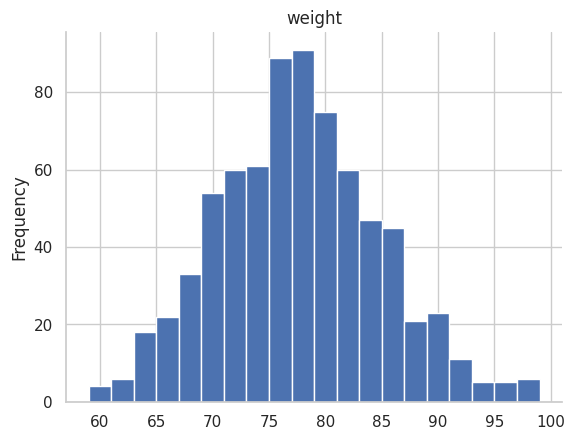

In [24]:
# Plot a histogram of the 'weight' column in the DataFrame 'df_3'
df_3['weight'].plot(kind='hist', bins=20, title='weight')

# Remove the top and right spines from the plot for a cleaner look
plt.gca().spines[['top', 'right']].set_visible(False)

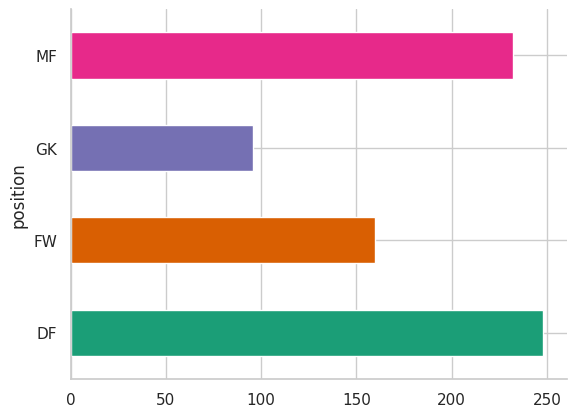

In [22]:
_df_4.groupby('position').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

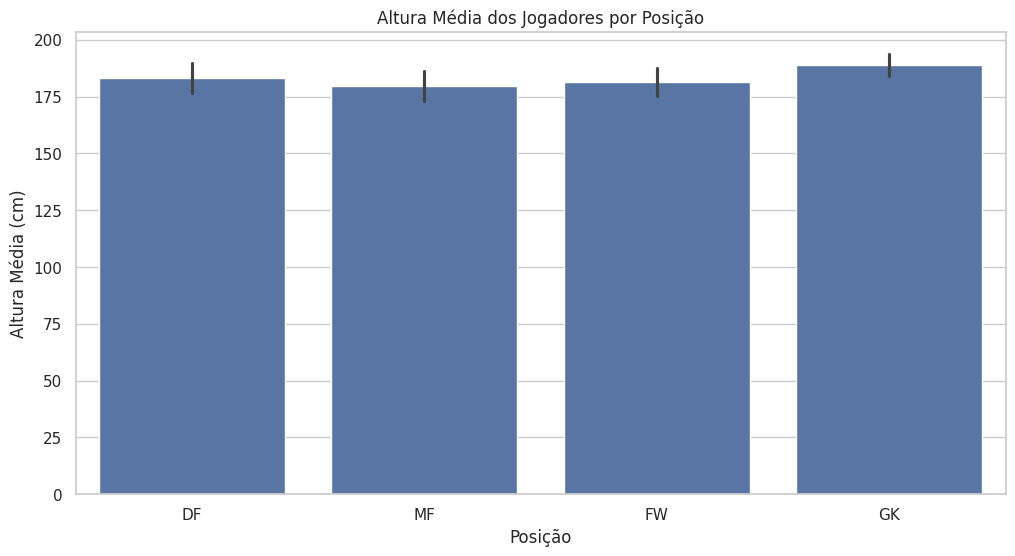

In [20]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x='position', y='height', data=df_pandas, errorbar='sd')

plt.title('Altura Média dos Jogadores por Posição')
plt.xlabel('Posição')
plt.ylabel('Altura Média (cm)')

plt.show()